In [1]:
!pip install gdown
!gdown --id 1-1EjRHAq-4nhXIJ9-OobWmMXavl1B4zn
!gdown --id 1uiL-O3EtAholf9qrtR8TlppjrGHW10Rh

/opt/conda/lib/python3.10/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1-1EjRHAq-4nhXIJ9-OobWmMXavl1B4zn
From (redirected): https://drive.google.com/uc?id=1-1EjRHAq-4nhXIJ9-OobWmMXavl1B4zn&confirm=t&uuid=f3b09ac8-4652-4a9a-8ef5-fb6196d176c8
To: /kaggle/working/data.pkl
100%|███████████████████████████████████████| 1.24G/1.24G [00:07<00:00, 165MB/s]
/opt/conda/lib/python3.10/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1uiL-O3EtAholf9qrtR8TlppjrGHW10Rh
To: /kaggle/working/3DECGNet.h5
100%|███████████████████████████████████████| 3.57M/3.57M [00:00<00:00, 197MB/s]


In [2]:
import pickle
from tqdm import tqdm
import tensorflow as tf
import numpy as np

from preprocess import data_preparation
from preprocess import signal_cutter
from preprocess import data_filtering
from preprocess import resampling
from preprocess import RP_3D
from preprocess import resize_volume
from preprocess import RP_final_data
from preprocess import label_creator
from preprocess import including_data
from lime_utils import tp_finder
from lime_utils import lead_replacing
from lime_utils import weight_bars

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Read dictionary pkl file
with open('/kaggle/working/data.pkl', 'rb') as fp:
    dataset = pickle.load(fp)

In [4]:
ds = data_preparation(dataset)

# shortening
ds = signal_cutter(ds, d_length=1000)

# denoising
ds = data_filtering(ds)

# resampling
ds = resampling(ds, desired_points = 100)

100%|██████████| 10344/10344 [00:01<00:00, 7470.42it/s]


In [5]:
arr = {'NSR':'426783006', 'AF':'164889003', 'IAVB':'270492004', 'LBBB':'164909002', 'RBBB':'59118001', 'SB':'426177001', 'STach':'427084000'}
labels = label_creator(data_preparation(dataset), arr)
x_train, y_train, x_test, y_test = including_data(labels, ds)
# transformation and resizing
tmp_x_test = RP_final_data(x_test)

100%|██████████| 10344/10344 [00:00<00:00, 888326.79it/s]
10344it [00:07, 1303.37it/s]
10344it [00:04, 2208.91it/s]
100%|██████████| 1126/1126 [05:31<00:00,  3.39it/s]


In [6]:
model = tf.keras.models.load_model('/kaggle/working/3DECGNet.h5')
pred_proba = model.predict(tmp_x_test)
prediction = np.zeros(np.shape(pred_proba))
prediction[pred_proba > 0.5] = 1

36/36 [==============================] - 15s 339ms/step


In [7]:
neigh_mx = lead_replacing()
tp_samples = tp_finder(prediction, y_test, 'AF', arr)

In [8]:
from sklearn.linear_model import LogisticRegression
cof = []
for i in tp_samples:
    neighbors = []
    for j in neigh_mx:
        neighbors.append(j * x_test[i])
    neighbor_tr = RP_final_data(neighbors)
    p = model.predict(neighbor_tr)
    pp = np.zeros(np.shape(p))
    pp[p > 0.5] = 1
    wei = []
    for k in np.squeeze(neigh_mx):
        wei.append(sum(k)/12)
    lr = LogisticRegression()
    lr.fit(np.squeeze(neigh_mx), pp[:,1], sample_weight = wei)
    
    cof.append(lr.coef_)

100%|██████████| 793/793 [03:55<00:00,  3.37it/s]


25/25 [==============================] - 9s 356ms/step


100%|██████████| 793/793 [03:53<00:00,  3.39it/s]


25/25 [==============================] - 8s 337ms/step


100%|██████████| 793/793 [03:53<00:00,  3.40it/s]


25/25 [==============================] - 8s 337ms/step


100%|██████████| 793/793 [03:53<00:00,  3.40it/s]


25/25 [==============================] - 8s 337ms/step


100%|██████████| 793/793 [03:53<00:00,  3.40it/s]


25/25 [==============================] - 8s 337ms/step


100%|██████████| 793/793 [03:53<00:00,  3.40it/s]


25/25 [==============================] - 8s 337ms/step


100%|██████████| 793/793 [03:53<00:00,  3.40it/s]


25/25 [==============================] - 8s 337ms/step


100%|██████████| 793/793 [03:53<00:00,  3.40it/s]


25/25 [==============================] - 8s 337ms/step


100%|██████████| 793/793 [03:55<00:00,  3.37it/s]


25/25 [==============================] - 8s 337ms/step


100%|██████████| 793/793 [03:52<00:00,  3.41it/s]


25/25 [==============================] - 8s 338ms/step


100%|██████████| 793/793 [03:52<00:00,  3.40it/s]


25/25 [==============================] - 8s 337ms/step


100%|██████████| 793/793 [03:52<00:00,  3.41it/s]


25/25 [==============================] - 8s 337ms/step


100%|██████████| 793/793 [03:52<00:00,  3.41it/s]


25/25 [==============================] - 8s 337ms/step


100%|██████████| 793/793 [03:53<00:00,  3.39it/s]


25/25 [==============================] - 8s 337ms/step


100%|██████████| 793/793 [03:53<00:00,  3.40it/s]


25/25 [==============================] - 8s 337ms/step


100%|██████████| 793/793 [03:53<00:00,  3.40it/s]


25/25 [==============================] - 8s 337ms/step


100%|██████████| 793/793 [03:53<00:00,  3.40it/s]


25/25 [==============================] - 8s 338ms/step


100%|██████████| 793/793 [03:53<00:00,  3.40it/s]


25/25 [==============================] - 8s 337ms/step


100%|██████████| 793/793 [03:52<00:00,  3.41it/s]


25/25 [==============================] - 8s 337ms/step


100%|██████████| 793/793 [03:52<00:00,  3.41it/s]


25/25 [==============================] - 8s 337ms/step


100%|██████████| 793/793 [03:52<00:00,  3.40it/s]


25/25 [==============================] - 8s 337ms/step


100%|██████████| 793/793 [03:52<00:00,  3.41it/s]


25/25 [==============================] - 8s 337ms/step


100%|██████████| 793/793 [03:53<00:00,  3.40it/s]


25/25 [==============================] - 8s 337ms/step


100%|██████████| 793/793 [03:52<00:00,  3.41it/s]


25/25 [==============================] - 8s 337ms/step


100%|██████████| 793/793 [03:52<00:00,  3.41it/s]


25/25 [==============================] - 8s 337ms/step


100%|██████████| 793/793 [03:53<00:00,  3.40it/s]


25/25 [==============================] - 8s 337ms/step


100%|██████████| 793/793 [03:54<00:00,  3.38it/s]


25/25 [==============================] - 8s 337ms/step


100%|██████████| 793/793 [03:53<00:00,  3.39it/s]


25/25 [==============================] - 8s 337ms/step


100%|██████████| 793/793 [03:54<00:00,  3.39it/s]


25/25 [==============================] - 8s 338ms/step


100%|██████████| 793/793 [03:54<00:00,  3.39it/s]


25/25 [==============================] - 8s 338ms/step


100%|██████████| 793/793 [03:53<00:00,  3.39it/s]


25/25 [==============================] - 8s 337ms/step


100%|██████████| 793/793 [03:54<00:00,  3.39it/s]


25/25 [==============================] - 8s 338ms/step


100%|██████████| 793/793 [03:53<00:00,  3.39it/s]


25/25 [==============================] - 8s 337ms/step


100%|██████████| 793/793 [03:53<00:00,  3.39it/s]


25/25 [==============================] - 8s 337ms/step


100%|██████████| 793/793 [03:53<00:00,  3.39it/s]


25/25 [==============================] - 8s 337ms/step


100%|██████████| 793/793 [03:53<00:00,  3.39it/s]


25/25 [==============================] - 8s 337ms/step


100%|██████████| 793/793 [03:53<00:00,  3.39it/s]


25/25 [==============================] - 8s 337ms/step


100%|██████████| 793/793 [03:53<00:00,  3.39it/s]


25/25 [==============================] - 8s 338ms/step


100%|██████████| 793/793 [03:53<00:00,  3.39it/s]


25/25 [==============================] - 8s 337ms/step


100%|██████████| 793/793 [03:52<00:00,  3.40it/s]


25/25 [==============================] - 8s 337ms/step


100%|██████████| 793/793 [03:53<00:00,  3.40it/s]


25/25 [==============================] - 8s 338ms/step


100%|██████████| 793/793 [03:52<00:00,  3.41it/s]


25/25 [==============================] - 8s 337ms/step


100%|██████████| 793/793 [03:52<00:00,  3.40it/s]


25/25 [==============================] - 8s 337ms/step


100%|██████████| 793/793 [03:53<00:00,  3.40it/s]


25/25 [==============================] - 8s 337ms/step


100%|██████████| 793/793 [03:52<00:00,  3.41it/s]


25/25 [==============================] - 8s 337ms/step


100%|██████████| 793/793 [03:52<00:00,  3.41it/s]


25/25 [==============================] - 8s 338ms/step


100%|██████████| 793/793 [03:52<00:00,  3.41it/s]


25/25 [==============================] - 8s 337ms/step


100%|██████████| 793/793 [03:52<00:00,  3.41it/s]


25/25 [==============================] - 8s 337ms/step


100%|██████████| 793/793 [03:52<00:00,  3.42it/s]


25/25 [==============================] - 8s 336ms/step


100%|██████████| 793/793 [03:51<00:00,  3.42it/s]


25/25 [==============================] - 8s 336ms/step


100%|██████████| 793/793 [03:51<00:00,  3.43it/s]


25/25 [==============================] - 8s 336ms/step


100%|██████████| 793/793 [03:51<00:00,  3.43it/s]


25/25 [==============================] - 8s 336ms/step


100%|██████████| 793/793 [03:51<00:00,  3.42it/s]


25/25 [==============================] - 8s 337ms/step


In [51]:
cf2 = np.squeeze(cof)

In [52]:
my_dict = {
    'Lead I':cf2[:,0],
    'Lead II':cf2[:,1],
    'Lead III':cf2[:,2],
    'Lead avF':cf2[:,3],
    'Lead avR':cf2[:,4],
    'Lead avL':cf2[:,5],
    'Lead V1':cf2[:,6],
    'Lead V2':cf2[:,7],
    'Lead V3':cf2[:,8],
    'Lead V4':cf2[:,9],
    'Lead V5':cf2[:,10],
    'Lead V6':cf2[:,11]
}

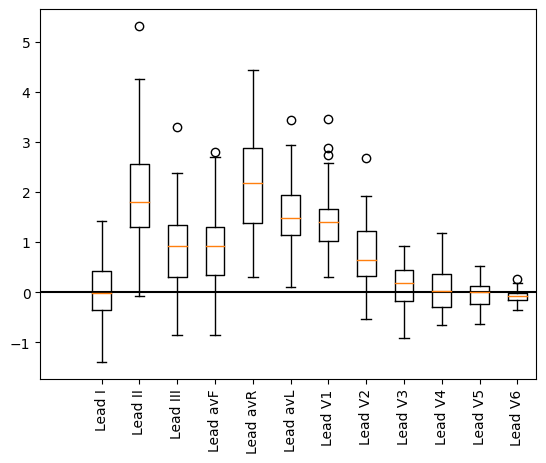

In [53]:
fig, ax = plt.subplots()
ax.boxplot(my_dict.values())
plt.axline((0,0),(11,0),color='black')
ax.set_xticklabels(my_dict.keys())
plt.xticks(rotation=90)
plt.show()

In [36]:
np.savez('/kaggle/working/AFweights' , cf2)